In [1]:
import glob
import os
import random
from datetime import datetime

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import tensorflow as tf
import tensorflow.python.platform.build_info as build
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import datasets, layers, models
from tensorflow.python.client import device_lib

from spec_generator_sequence import spec_generator
from spec_input_generator import gen, gen_eval
# import spectrogram
# from spectrogram import generate_spec
# from spectrogram import truncate_spec
# from spectrogram import mask_spec
# from spectrogram import add_noise
# from spectrogram import path_to_preprocessing
from spectrogram_class import spectrogram


# OrchideaSOL CNN 

This notebooks is succesive from the baseline model notebook from music_transcription_class.ipynb.

In the notebook, we had demonstrate the limitation of simple CNN model on classifying instruments from raw audio files.

In this notebook, we will be running a similar CNN architecture, but with deeper layers, and applying regularization, batch normalization and dropout techniques.

In [2]:
print(build.build_info['cuda_version'])

11.2


In [3]:
device_lib.list_local_devices()

2022-08-07 05:18:24.777297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 05:18:24.814522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:24.844265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:24.845080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3808784488640029326
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3534618624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10896450028566912347
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-07 05:18:25.723997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


True

2022-08-07 05:18:25.724627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:25.725133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:25.725688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:25.726083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:25.726402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 3

In [5]:
tf.config.list_physical_devices('GPU')

2022-08-07 05:18:25.835047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:25.835717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:25.836308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We first start by generating training and testing dataset as usual.

In [7]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [8]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [11]:
train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                        train_size=0.8)

In [12]:
train_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
11993,Winds/Clarinet_Bb/sforzato/ClBb-sfz-F5-f-N-T10...,Winds,Woodwinds,ClBb,Clarinet in Bb,sfz,sforzato,F5,77.0,f,3.0,0.0,N,None,NaN,True,2
12210,Winds/Flute/flatterzunge/Fl-flatt-C#6-ff-N-N.wav,Winds,Woodwinds,Fl,Flute,flatt,flatterzunge,C#6,85.0,ff,4.0,0.0,N,None,NaN,False,3


In [13]:
sample = next(gen(train_df, return_class = True))

In [14]:
spec_shape = sample[0].spec.shape
spec_shape

(256, 500, 1)

In [15]:
next(gen_eval(test_df))[0].shape

(256, 500, 1)

In [16]:

# BATCH_SIZE = 16 

# train_generator = (tf.data.Dataset.from_generator(lambda: gen(train_df), output_types=(tf.complex64, tf.int64), 
#                  output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)

# eval_generator = (tf.data.Dataset.from_generator(lambda: gen_eval(test_df), output_types=(tf.complex64, tf.int64), 
#                  output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


We will be using the same Sequence data generator, as in previous notebook. However, to optimize our performance, we will be converting the generator in to a tf Dataset object, and optimized the performance by prefetching the dataset while fitting is in progress.

The process of prefecthing and training can be visualized using [tf.data API](https://www.tensorflow.org/guide/data_performance). Which is in the todo list of this project.

In [26]:
BATCH_SIZE = 32

train_generator = (tf.data.Dataset.from_generator(lambda: spec_generator(train_df, BATCH_SIZE, 
                  add_channel = True), output_types=(tf.float32, tf.int32), 
                 output_shapes = ((BATCH_SIZE, spec_shape[0], spec_shape[1], 1), 
                 (BATCH_SIZE, 16)))).prefetch((tf.data.experimental.AUTOTUNE))

eval_generator = (tf.data.Dataset.from_generator(lambda: spec_generator(test_df, BATCH_SIZE, 
                  add_channel = True), 
                    output_types=(tf.float32, tf.int32), 
                 output_shapes = ((BATCH_SIZE, spec_shape[0], spec_shape[1], 1), 
                 (BATCH_SIZE, 16)))).prefetch((tf.data.experimental.AUTOTUNE))


In [27]:
train_generator

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 256, 500, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 16), dtype=tf.int32, name=None))>

Now we can finally start to build our model, the idea is same as before, a deeper convolutional model, including dropouts and regularization.

In [28]:
# Starting the model
model_2conv = models.Sequential()

# Adding the first convoluton-pooling layer
model_2conv.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1),
                     batch_size = BATCH_SIZE, dtype = tf.float32))
model_2conv.add(layers.Conv2D(30, (150, 300), activation='relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(l2=0.01)))
model_2conv.add(layers.MaxPool2D((2, 3)))

# Addig the second convolutional-pooling layer
model_2conv.add(layers.Conv2D(30, (15, 30), activation = 'relu',
                                kernel_regularizer = tf.keras.regularizers.L2(l2=0.01)))
model_2conv.add(layers.MaxPool2D(2, 3))

# Combined the filter layers into 1
model_2conv.add(layers.Flatten())
model_2conv.add(layers.Dropout(0.2))
model_2conv.add(layers.Dense(50, activation = 'relu'))
model_2conv.add(layers.Dropout(0.2))

# Final layer to classify the 16 instruments
# We are using softmax activation since this is a multiclass classification problem
model_2conv.add(layers.Dense(16, activation = 'softmax'))

model_2conv.build()

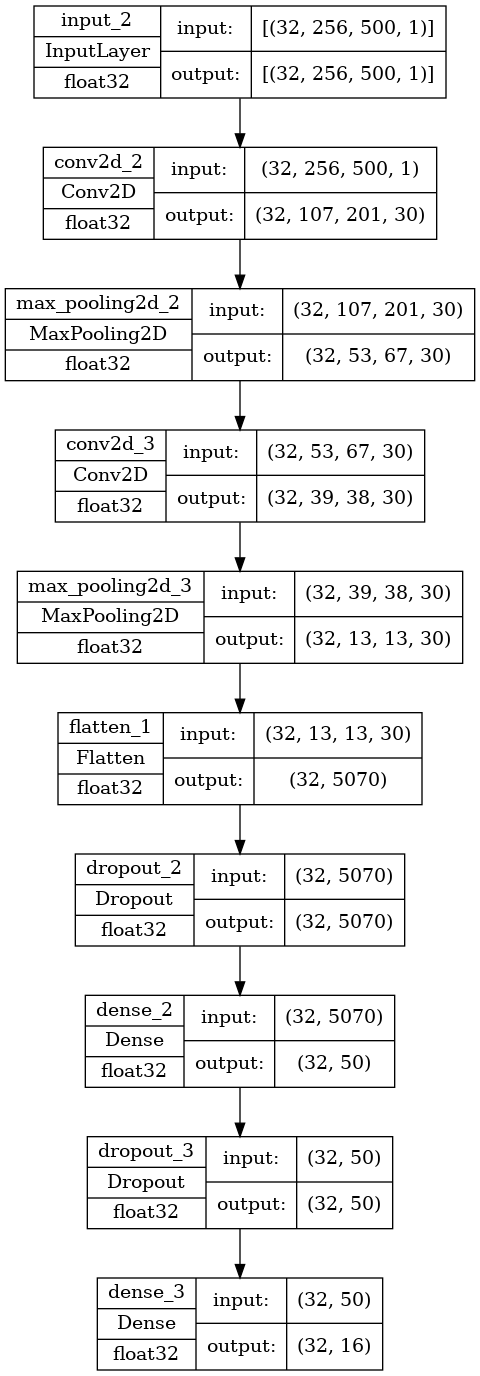

In [29]:
tf.keras.utils.plot_model(model_2conv, show_shapes = True, show_dtype= True)

Our input shape will be the same as in the previous notebook, with 256 frequency bins and 500 timesteps

Our output layer consists of 16 neurons, each representing one possible instrument class. 

Since we will be predicting a multiclass label (Only one true label over multiple options), we will be using categorical cross entropy as our loss function, note the this is the reason why we have chose to use softmax as the activation function of our output layer.

In [30]:

model_2conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
model_2conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (32, 107, 201, 30)        1350030   
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 53, 67, 30)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (32, 39, 38, 30)          405030    
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 13, 13, 30)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (32, 5070)                0         
                                                                 
 dropout_2 (Dropout)         (32, 5070)               

In [32]:
#  model_2conv = tf.keras.models.load_model('../models/2conv/six/')

In [34]:
# ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model_2conv", 
#                                                     monitor='val_accuracy')
# early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


# history = model_2conv.fit(train_generator, epochs = 4, verbose=1, 
#                     validation_data = eval_generator,
#                     validation_steps = 10, validation_freq= 2, 
#                     use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

Epoch 1/4


2022-08-07 05:21:13.144486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-07 05:21:16.141726: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 05:21:16.142514: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 05:21:16.142536: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-07 05:21:16.143172: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 05:21:16.143249: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


    331/Unknown - 1751s 5s/step - loss: 373.0717 - accuracy: 0.1480

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_01_model_2conv/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_01_model_2conv/assets


331/331 [==============================] - 1759s 5s/step - loss: 373.0717 - accuracy: 0.1480
Epoch 2/4
331/331 [==============================] - ETA: 0s - loss: 68.0334 - accuracy: 0.1514

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_02_model_2conv/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_02_model_2conv/assets


331/331 [==============================] - 1700s 5s/step - loss: 68.0334 - accuracy: 0.1514 - val_loss: 40.4781 - val_accuracy: 0.1562
Epoch 3/4
331/331 [==============================] - ETA: 0s - loss: 57.7921 - accuracy: 0.1516

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_03_model_2conv/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_03_model_2conv/assets


331/331 [==============================] - 1691s 5s/step - loss: 57.7921 - accuracy: 0.1516
Epoch 4/4
331/331 [==============================] - ETA: 0s - loss: 22.4835 - accuracy: 0.1463

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_04_model_2conv/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220807_052111_04_model_2conv/assets


331/331 [==============================] - 1701s 5s/step - loss: 22.4835 - accuracy: 0.1463 - val_loss: 14.2778 - val_accuracy: 0.1469


In [35]:
model_2conv.save('../models/new_OrchideaSOL_2conv/')

INFO:tensorflow:Assets written to: ../models/new_OrchideaSOL_2conv/assets


INFO:tensorflow:Assets written to: ../models/new_OrchideaSOL_2conv/assets


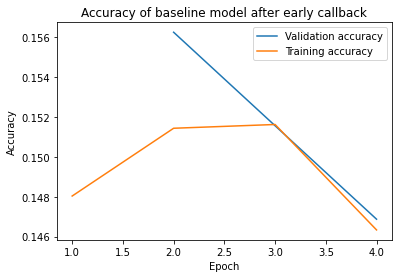

In [39]:
# plt.plot([2, 4], history.history['val_accuracy'], label = 'Validation accuracy')
# plt.plot([1, 2, 3, 4], history.history['accuracy'], label = 'Training accuracy')
# plt.title('Accuracy of baseline model after early callback')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

The figure above shows the accuracy of 4 epochs we have ran, combining with the our baseline model of one convolutional layers, we can conclude that basic CNN since to be performing poorly on this problem. Since

* Both the validation and training accuracy starts to drop after 3 epochs
* Training time is around 30 minutes per epoch

We can still look at the loos function 

In [1]:
# plt.plot([2, 4], history.history['val_loss'], label = 'Validation loss')
# plt.plot([1, 2, 3, 4], history.history['loss'], label = 'Training loss')
# plt.title('Loss of baseline model after early callback')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

NameError: name 'plt' is not defined

***I have mistakenly run the code without saving the history, and lost the plot  
The general shape of the figure is a sharp drop at first spoch, and remained fairly strat with minimal decrease after that***

The loss function hardly decrease after the first epoch, however, both the decerase of loss function and accuracy represents that the categorical cross entropy might not be the best choice for such classification problem.

But the model might inprove after several epoch, this notebook is yet to be run again with longer time after the more important preceeding notebooks (Sequential music transcription with LSTM) had been done.

Also the hyperparameter such as the number of frequency bins, optimizer and regularization coefficient still can be optimized. Due to the limited time and high training time, this notebook had been added to the to do list, and decreased in priority.